# Linear Mixed Models

#### Set up environment

In [2]:
%matplotlib inline

import sys
import scipy as sp
import scipy.stats as st
import pylab as pl
import pandas as pd
sp.random.seed(0)

import limix.util as lmx_util
import limix.plot as lmx_plt

#### Download data

We here load the arabidopsis dataset.
The data used in this study have been pre-converted into an hdf5 file. 
To preprocess your own data, please use limix command line brinary.

In [3]:
sys.path.append('./..')
import data as tutorial_data
file_name = tutorial_data.get_file('arab107')

#### Set up data object

The data object allows to query specific genotype or phenotype data

In [4]:
from limix.io import genotype_reader as gr
from limix.io import phenotype_reader as phr
from limix.io import data

In [5]:
geno_reader  = gr.genotype_reader_tables(file_name)
pheno_reader = phr.pheno_reader_tables(file_name)
dataset = data.QTLData(geno_reader=geno_reader,pheno_reader=pheno_reader)

#### Select flowering time phenotypes

In [6]:
#flowering phenotypes
phenotype_names = ['5_FT10','6_FT16','7_FT22']
phenotype_ID =  phenotype_names[1]

In [8]:
#load first flowering phenotype
#phenotype_query = "(phenotype_ID=='%s')" %  phenotype_ID
phenotype_query = "(phenotype_ID in %s)" %  str(phenotype_names)

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

if 1:
    #subsample for speed?
    Is = sp.arange(dataset.geno_pos.shape[0])
    #take every 10th SNP
    Is = Is[::10]
    data_subsample = data_subsample.subsample(cols_geno = Is)

    
#get variables we need from data
snps = data_subsample.getGenotypes(center=False,unit=False)
position = data_subsample.getPos()

phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True) 
phenotype_std = lmx_util.preprocess.rankStandardizeNormal(phenotypes.values)

N = snps.shape[0]
S = snps.shape[1]
P = phenotypes.shape[1]
print "loaded %d samples, %d phenotypes, %s snps" % (N,P,S)

loaded 192 samples, 3 phenotypes, 21456 snps


/Users/casale/anaconda/lib/python2.7/site-packages/limix_legacy-0.8.11-py2.7-macosx-10.6-x86_64.egg/limix_legacy/io/phenotype_reader.py:133: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 199 but corresponding boolean dimension is 192
  phenotypes = pd.DataFrame(data=phenotypes, index=self.sample_ID[sample_idx_intersect],columns=self.phenotype_ID[I])


# Standard linear regression

The function for standard linear regression in LIMIX is ``limix.qtl.qtl_test_lm`` (see [here][1]).

[1]:http://limix.readthedocs.io/qtl.html#limix.qtl.qtl_test_lm

In [11]:
from limix.qtl import qtl_test_lm

In [12]:
#set parameters for analysis
covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

Note that when cov are not set (None), LIMIX considers an intercept (i.e., ``covs=sp.ones((N,1))``).

In [13]:
# running the analysis
lm = qtl_test_lm(snps=snps,pheno=phenotype_std,
                   covs=covs, test=test)
pv_lm = lm.getPv() # 1xS vector of p-values

For nice output writing, P-values are converted to a DataFrame:

In [14]:
pvalues_lm = pd.DataFrame(data=pv_lm.T,
                          index=data_subsample.geno_ID,
                          columns=phenotypes.columns)

#### Manhattan plot

The LIMIX function for producing Manhattan plots is ``limix.plot.plot_manhattan`` (see [here][1]).

[1]:http://limix.readthedocs.io/plot.html#limix.plot.plot_manhattan

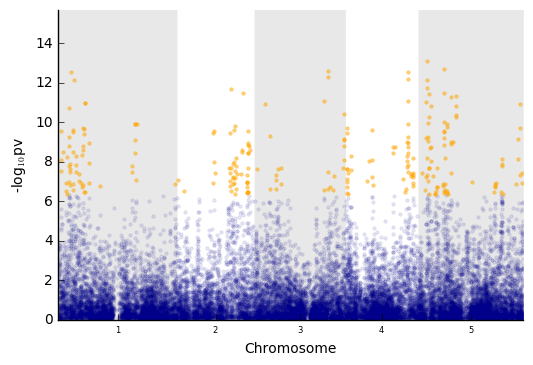

In [18]:
lmx_plt.plot_manhattan(pvalues_lm[phenotype_ID].values, position)

#### QQ plot

The function in LIMIX to produce QQ plots is ``limix.plot.qqplot`` (see [here][1]).

[1]:http://limix.readthedocs.io/plot.html#limix.plot.qqplot

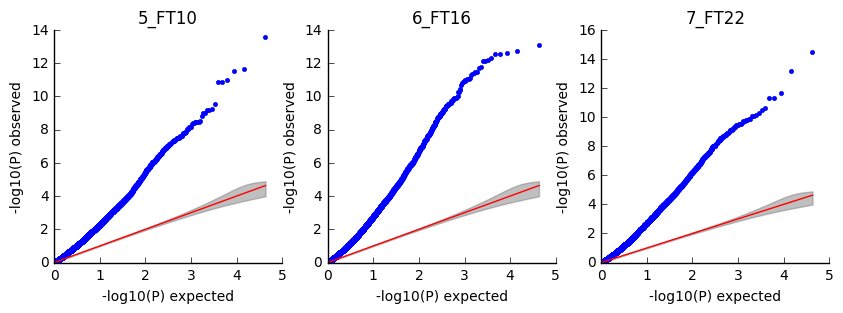

In [26]:
pl.figure(figsize=[10,3])
for ip in xrange(len(phenotype_names)):
    plt = pl.subplot(1,3,ip+1)
    lmx_plt.qqplot(pvalues_lm[phenotype_names[ip]].values)
    pl.title(phenotype_names[ip])

# Accounting for population structure based on PCA

One way to account for population structure in association testing is to add the leading principal components of the genotype data as additional covariates.

#### Compute principal component using sklearn

In [38]:
import sklearn.decomposition.pca as pca
pc = pca.PCA()
pc_snps = pc.fit_transform(snps)

#### Two-dimensional representation of the genotype data

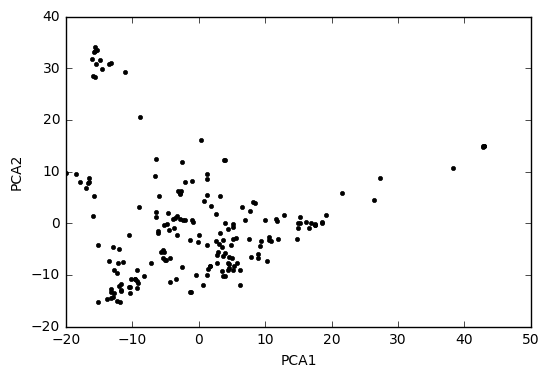

In [39]:
pl.plot(pc_snps[:,0],pc_snps[:,1],'k.')
pl.xlabel('PCA1')
pl.ylabel('PCA2')

#### Plot proportion of variance explained by each PC

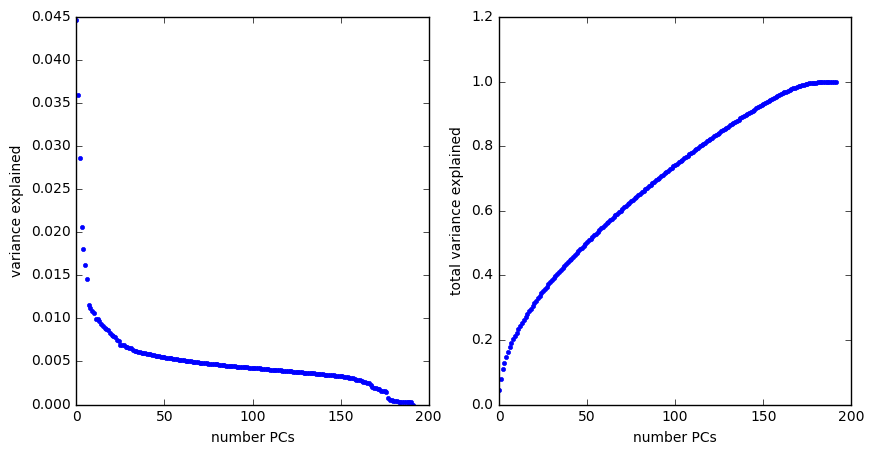

In [40]:
pl.figure(figsize=(10,5))
pl.subplot(1,2,1)
pl.plot(pc.explained_variance_ratio_,".")
pl.xlabel("number PCs")
pl.ylabel("variance explained")

pl.subplot(1,2,2)
pl.plot(pc.explained_variance_ratio_.cumsum(),".")
pl.xlabel("number PCs")
pl.ylabel("total variance explained")

#### Running a linear model with PC correction

We here consider association testing with linear models considering an increasing number of genotype principal components and plot the corresponding QQ-plots.

In [41]:
covs_with_pcs = sp.concatenate([sp.ones([snps.shape[0],1]),pc_snps],axis=1)
n_components = [0,1,5,10,30]

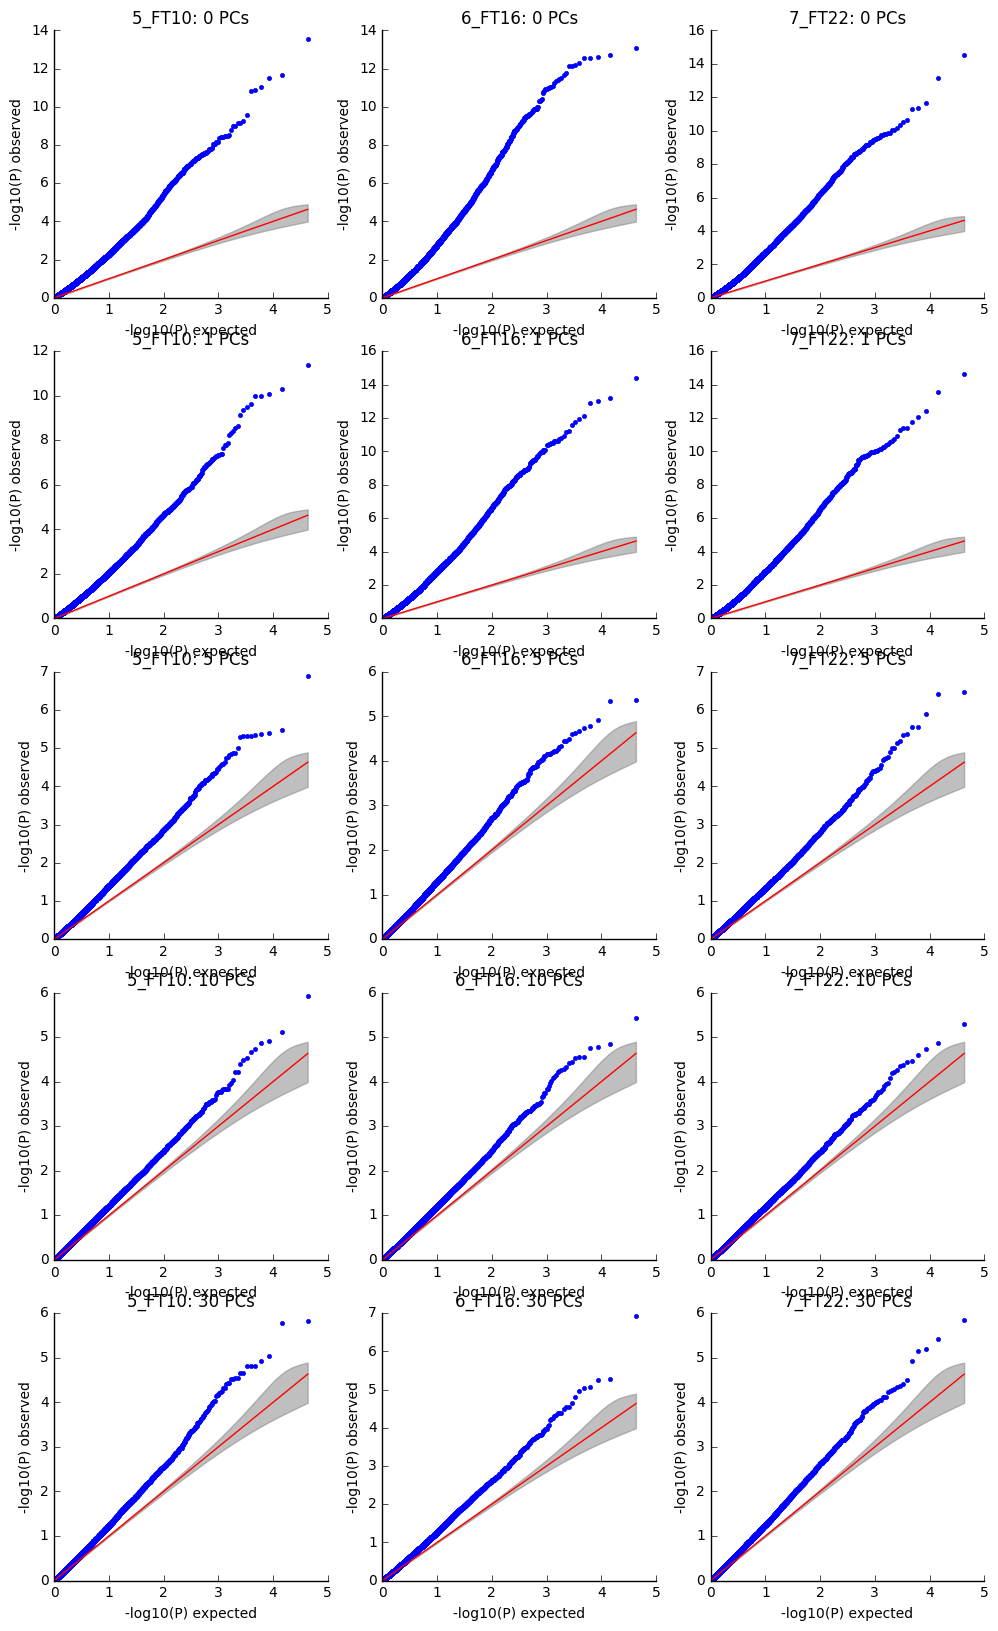

In [44]:
pl.figure(figsize=[12,20])

ip = 1
for i in n_components:

    _covs = covs_with_pcs[:,0:i+1]

    lm = qtl_test_lm(snps=snps,pheno=phenotype_std,covs=_covs, test=test)
    
    pvalues_lm = pd.DataFrame(data=lm.getPv().T,
                              index=data_subsample.geno_ID,
                              columns=phenotypes.columns)

    # make qq plot
    for phenotype_ID in phenotype_names:
        plt = pl.subplot(len(n_components),len(phenotype_names),ip)
        lmx_plt.qqplot(pvalues_lm[phenotype_ID].values) 
        ip+=1
        pl.title('%s: %d PCs' % (phenotype_ID,i))

# Linear mixed models

#### Genetic relatedness matrix

In [52]:
#estimate genetic relatedness
sample_relatedness_unnormalized = data_subsample.getCovariance(normalize=True, center=True)

In [53]:
#normalize it
sample_relatedness = sample_relatedness_unnormalized.copy()
sample_relatedness/= sample_relatedness.diagonal().mean()

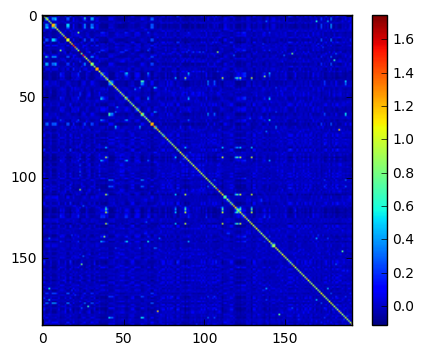

In [54]:
#plot it
pl.figure(1, figsize=(5,4))
pl.imshow(sample_relatedness,aspect='auto')
pl.colorbar()

#### Linear mixed model

Association testig with linear mixed models can be performed using the function ``limix.qtl.qtl_test_lmm`` (see [here][1]).

[1]:http://limix.readthedocs.io/qtl.html#limix.qtl.qtl_test_lmm

In [58]:
from limix.qtl import qtl_test_lmm

In [59]:
#settings
covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

In [60]:
#linear mixed model
lmm = qtl_test_lmm(snps=snps,
                   pheno=phenotype_std,
                   K=sample_relatedness,
                   covs=covs,
                   test=test)

In [68]:
# retrieve important quantities
pv_lmm = lmm.getPv() # P values
beta_lmm = lmm.getBetaSNP() # effect sizes
beta_ste_lmm = lmm.getBetaSNPste() # standard errors

Convert P-values to a DataFrame for nice output writing:

In [69]:
pvalues_lmm = pd.DataFrame(data=pv_lmm.T,
                           index=data_subsample.geno_ID,
                           columns=phenotypes.columns)

#### QQ plot for LMM P-values

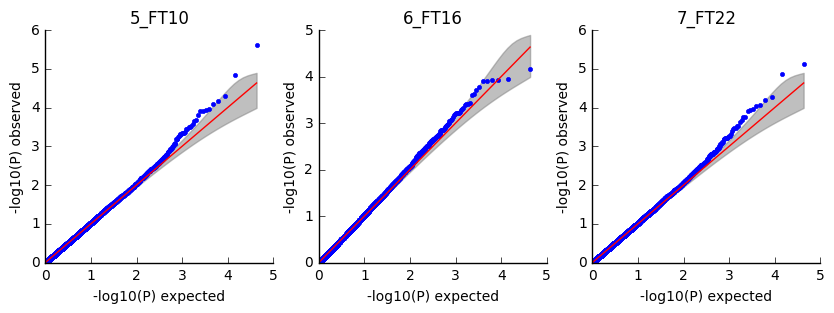

In [73]:
pl.figure(figsize=[10,3])
for ip in xrange(len(phenotype_names)):
    plt = pl.subplot(1,3,ip+1)
    lmx_plt.qqplot(pvalues_lmm[phenotype_names[ip]].values)
    pl.title(phenotype_names[ip])

#### Compare to Linear model

For comparison, we here also consider a linear model.

In [74]:
lm = qtl_test_lm(snps=snps,
                 pheno=phenotype_std,
                 covs=covs,
                 test=test)
pvalues_lm = lm.getPv() # 1xS vector of p-values (S=X.shape[1])#convert P-values to a DataFrame for nice output writing:
pvalues_lm = pd.DataFrame(data=pvalues_lm.T,
                          index=data_subsample.geno_ID,
                          columns=phenotypes.columns)

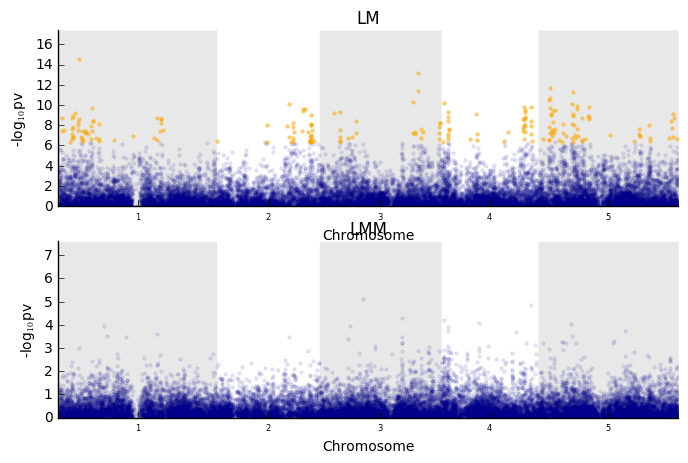

In [78]:
pl.figure(figsize=[8,5])
plt = pl.subplot(2,1,1)
lmx_plt.plot_manhattan(pvalues_lm[phenotype_ID].values, position)
pl.title('LM')
plt = pl.subplot(2,1,2)
lmx_plt.plot_manhattan(pvalues_lmm[phenotype_ID].values, position)
pl.title('LMM')